In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import scipy
import pickle
import warnings
import bidict
import collections

import sys
sys.path.append('..')
from construct_graph.graph import Graph, Flat
import construct_graph
import solve_laplace_operator

import sparseqr

from IPython.display import display, HTML

display(HTML("""
<style>
.jp-OutputArea-output {max-width: 100% !important;}
.jp-Cell-outputWrapper {max-width: 100% !important;}
.jp-OutputArea-output pre {max-width: 100% !important;}
</style>
"""))

def calculate_pde_eigenvalues(m, n):
    a = 1 / 2
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * a)

In [2]:
class Renormalization:

    def __init__(self, g, partition_type="by_tile", num_patches_per_dim=None, autoplot=True):

        self.g = g
        self.partition_type = partition_type

        if self.partition_type == "by_patch":
            self.num_patches_per_dim = num_patches_per_dim
            self.num_patches = self.num_patches_per_dim**2
            self.patch_side_length = 1.0 / self.num_patches_per_dim
        elif self.partition_type == "by_tile":
            self.num_patches = (self.g.num_horizontal_displacements 
                                * self.g.num_vertical_displacements)

        self.super_V_coords, self.patch_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

        if autoplot:
            self.plot_patching(figsize=5)

    def __call__(self, calculation="full"):

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(self.num_patches)]
            T = [0 for _ in range(self.num_patches)]

            for v, w in self.E_data:
                
                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                fac = (r_ij + alpha_w - alpha_v)
                T[self.V_to_super_V[v]["patch_num"]] += l_vw
                Q[self.V_to_super_V[v]["patch_num"]] += fac[:, None] @ fac[None, :] / l_vw

        return Q, T
    
    def solve_for_bilinear_coefficients(self):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw

            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = scipy.sparse.linalg.lsqr(C, Dx)[0] 
        alpha_y = scipy.sparse.linalg.lsqr(C, Dy)[0]

        return alpha_x, alpha_y

    def partition_graph(self):
        
        super_V_coords = []
        V_to_super_V = {}
        super_V_to_V = collections.defaultdict(list)
        patch_coords = []

        if self.partition_type == "by_tile":

            tile_num = -1
            for row in range(self.g.num_vertical_displacements):
                for col in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"patch_num": tile_num, 
                                                 "patch_indices": np.array([col, row])}

            # Calculate x, y translations by looking at displacements between tiles
            max_displacement = np.max([self.g.horizontal_displacement, self.g.vertical_displacement])
            horizonal_displacement = (self.g.horizontal_displacement / max_displacement 
                                      / self.g.num_horizontal_displacements)
            vertical_displacement = (self.g.vertical_displacement / max_displacement 
                                     / self.g.num_vertical_displacements)

            translations = np.array([horizonal_displacement, vertical_displacement])

        elif self.partition_type == "by_patch": 

            # Create the patch_coords
            for row in range(self.num_patches_per_dim):
                for col in range(self.num_patches_per_dim):
                    center_x = (col + 0.5) * self.patch_side_length
                    center_y = (row + 0.5) * self.patch_side_length
                    patch_coords.append([center_x, center_y])
            patch_coords = np.array(patch_coords)

            # Assign each vertex to the corresponding patch
            for v_num, (x, y) in enumerate(self.g.V_coords):
                patch_col = np.floor(x / self.patch_side_length).astype(int)
                patch_row = np.floor(y / self.patch_side_length).astype(int)
                patch_num = patch_row * self.num_patches_per_dim + patch_col
                V_to_super_V[v_num] = {"patch_num": patch_num, 
                                       "patch_indices": np.array([patch_col, patch_row])}
                super_V_to_V[patch_num].append(v_num)
                
            # Create super_V_coords
            super_V_coords = []
            for patch_num in range(self.num_patches):
                if self.g.V_coords[super_V_to_V[patch_num]].size == 0:
                    super_V_coords.append(None)
                else:
                    super_V_coords.append(np.mean(self.g.V_coords[super_V_to_V[patch_num]], axis=0))
            # super_V_coords = np.array(super_V_coords)  

            self.super_V_to_V = super_V_to_V      

            translations = np.array([self.patch_side_length, self.patch_side_length])

        return super_V_coords, patch_coords, V_to_super_V, translations
    
    def construct_E_data(self):

        E_data = {}

        if self.partition_type == "by_tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges:
                    a, b = (v % self.g.num_Vs_for_tile), (w % self.g.num_Vs_for_tile) 

                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                    i, j = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "by_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: 

                    i_index = self.V_to_super_V[v]["patch_indices"].copy()
                    j_index = self.V_to_super_V[w]["patch_indices"].copy()
                    ji_ind_dif = j_index - i_index
                    patch_i_coords = self.super_V_coords[self.V_to_super_V[v]["patch_num"]].copy()
                    patch_j_coords = self.super_V_coords[self.V_to_super_V[w]["patch_num"]].copy()

                    if ji_ind_dif[0] == self.num_patches_per_dim - 1:
                        patch_j_coords[0] -= 1
                    elif ji_ind_dif[0] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[0] += 1
                    if ji_ind_dif[1] == self.num_patches_per_dim - 1:
                        patch_j_coords[1] -= 1
                    elif ji_ind_dif[1] == -(self.num_patches_per_dim - 1):
                        patch_j_coords[1] += 1

                    r_ij = patch_j_coords - patch_i_coords

                else:
                    i_num, j_num = self.V_to_super_V[v]["patch_num"], self.V_to_super_V[w]["patch_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def plot_patching(self, figsize=10, linewidth=2,
                      return_figax=False, plot_V_nums=False):
        
        if self.partition_type == "by_tile":
            raise ValueError("Plotting for partitioning by tile not yet implemented")

        fig, ax = self.g.plot_graph(return_figax=True, figsize=figsize, linewidth=linewidth)
        for center in self.patch_coords:
            bottom_corner = (center[0] - self.patch_side_length / 2, center[1] - self.patch_side_length / 2)
            square = matplotlib.patches.Rectangle(bottom_corner, self.patch_side_length, self.patch_side_length,
                                                  linewidth=2 * linewidth, 
                                                  edgecolor='r', facecolor=(0.8, 0.8, 0.8, 0.1), alpha=1)
            ax.add_patch(square)
        ax.set_xlim(-0.1, 1.1)
        ax.set_ylim(-0.1, 1.1)

        if plot_V_nums:
            for v_num, v_coord in enumerate(self.g.V_coords):
                ax.annotate(str(v_num), v_coord, fontsize=20)

        if return_figax:
            return fig, ax
        plt.show()


|V| = 100


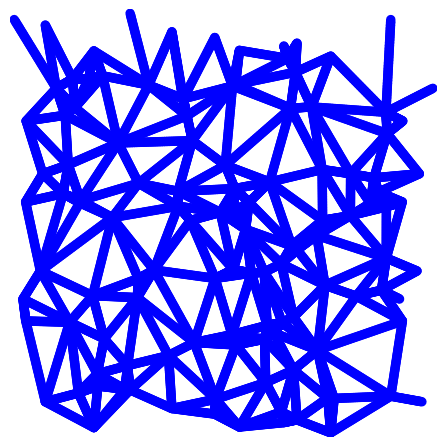

In [101]:
N = 1
num_Vs_for_tile = 100
np.random.seed(0)
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=True, figsize=5)

In [44]:
from scipy.sparse import diags, kron, identity

def finite_difference_matrix_2d(n):
    """
    Generate a 2D finite difference matrix with periodic boundary conditions for an n x n grid.
    
    Parameters:
    n (int): Number of grid points in each dimension
    
    Returns:
    scipy.sparse.csr_matrix: 2D finite difference matrix with periodic boundaries
    """
    # 1D finite difference matrix with periodic boundaries
    main_diag = -2 * np.ones(n)
    off_diag = np.ones(n - 1)
    diagonals = [main_diag, off_diag, off_diag]
    positions = [0, 1, -1]
    
    D_1d = diags(diagonals, positions, shape=(n, n), format='csr')
    D_1d = D_1d.tolil()
    D_1d[0, -1] = 1
    D_1d[-1, 0] = 1
    D_1d = D_1d.tocsr()
    
    # Identity matrix
    I_n = identity(n, format='csr')
    
    # 2D finite difference matrix using Kronecker product
    D_2d = kron(I_n, D_1d) + kron(D_1d, I_n)
    
    return D_2d * 1 / np.sqrt(n)

In [53]:
# Example usage
n = 30
L = finite_difference_matrix_2d(n)
ones_row = np.ones((1, n**2))
C = scipy.sparse.csc_matrix(np.vstack([L.toarray(), ones_row]))

In [54]:
print("For L:")
u, s, vt = scipy.sparse.linalg.svds(L, k=1, which='LM', maxiter=50000)
largest_singular_value = s[0]
u, s, vt = scipy.sparse.linalg.svds(L, k=2, which='SM', maxiter=50000)
smallest_nonzero_singular_value = s[0]
condition_number = largest_singular_value / smallest_nonzero_singular_value
print("Largest Singular Value of L:", largest_singular_value)
print("Smallest Non-zero Singular Value of L:", smallest_nonzero_singular_value)
print("Condition Number of L:", condition_number)
print()

print("For C:")
u, s, vt = scipy.sparse.linalg.svds(C, k=1, which='LM', maxiter=50000)
largest_singular_value = s[0]
u, s, vt = scipy.sparse.linalg.svds(C, k=2, which='SM', maxiter=50000)
smallest_nonzero_singular_value = s[0]
condition_number = largest_singular_value / smallest_nonzero_singular_value
print("Largest Singular Value of C:", largest_singular_value)
print("Smallest Non-zero Singular Value of C:", smallest_nonzero_singular_value)
print("Condition Number of C:", condition_number)

For L:
Largest Singular Value of L: 1.4605934866804426
Smallest Non-zero Singular Value of L: 7.629335490483661e-15
Condition Number of L: 191444390996082.47

For C:
Largest Singular Value of C: 30.000000000000643
Smallest Non-zero Singular Value of C: 0.007979368009135991
Condition Number of C: 3759.6962523412994


In [67]:
x = np.array([10, 20 ,30])
y = np.array([80, 913, 3759])
log_x = np.log(x)
log_y = np.log(y)
slope, intercept = np.polyfit(log_x, log_y, 1)

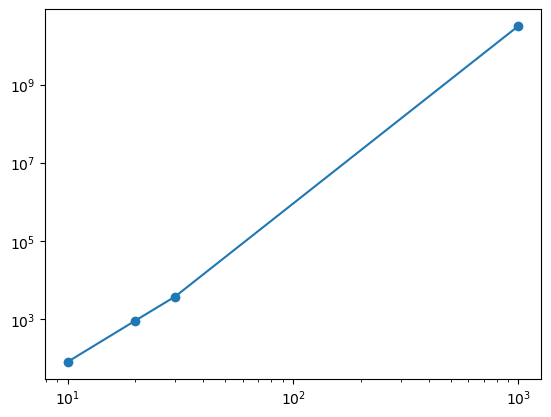

In [70]:
plt.loglog([10, 20 ,30, 1000], [80, 913, 3759, 1000**(3.5)], 'o-')

3.505199448790455


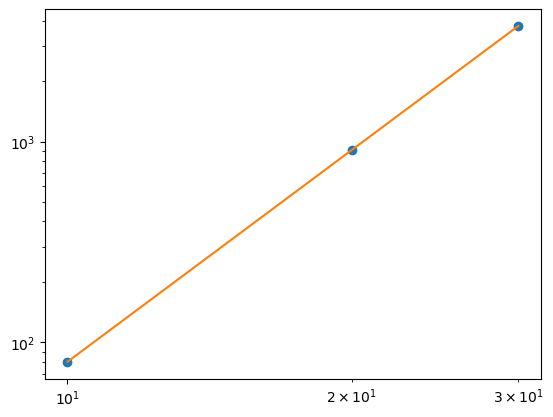

In [84]:
x = np.array([10, 20 ,30])
y = np.array([80, 913, 3759])

# Plot the data on a log-log scale
plt.loglog(x, y, 'o', label='Data')

# Perform linear regression on the log-transformed data
log_x = np.log10(x)
log_y = np.log10(y)
slope, intercept = np.polyfit(log_x, log_y, 1)
print(slope)

# Plot the fitted line
fitted_y = 10**(intercept) * x ** slope
plt.loglog(x, fitted_y, '-', label=f'Fit: y = x^{slope:.2f}')

3.5051994487904556


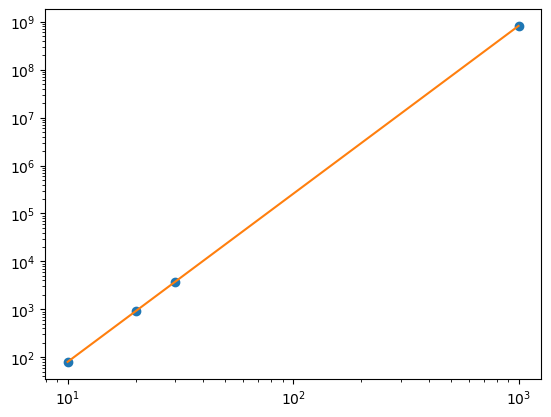

In [86]:
x = np.array([10, 20 ,30, 1000])
y = np.array([80, 913, 3759, 10**(slope * np.log10(1000) + intercept)])

# Plot the data on a log-log scale
plt.loglog(x, y, 'o', label='Data')

# Perform linear regression on the log-transformed data
log_x = np.log10(x)
log_y = np.log10(y)
slope1, intercept1 = np.polyfit(log_x, log_y, 1)
print(slope1)

# Plot the fitted line
fitted_y = 10**(intercept1) * x ** slope1
plt.loglog(x, fitted_y, '-', label=f'Fit: y = x^{slope:.2f}')

In [98]:
np.log10(10**(slope * np.log10(1000) + intercept))

8.914084816354144

In [92]:
10**(slope * np.log10(1000))*10**intercept

820511772.0664141

In [97]:
10000

10.5

In [16]:
# R = Renormalization(g, partition_type="by_tile", autoplot=False)
# L = scipy.sparse.lil_matrix((R.g.num_Vs, R.g.num_Vs))

# for v, w in R.E_data:

#     l_vw, r_ij = R.E_data[v, w]["l_vw"], R.E_data[v, w]["r_ij"]

#     L[v, w] -= 1 / l_vw
#     L[v, v] += 1 / l_vw

# ones_row = np.ones((1, R.g.num_Vs))
# C = scipy.sparse.csc_matrix(np.vstack([L.toarray(), ones_row]))

In [12]:
def construct_laplacian(n):
    """Construct the Laplacian matrix for a complete graph of size n."""
    data = np.ones(n) * n * 1/np.sqrt(n)
    L = scipy.sparse.diags(data, 0) - scipy.sparse.csc_matrix(np.ones((n, n))) * 1/np.sqrt(n)
    return L

def construct_C(n):
    """Construct the (n+1) x n matrix C with the first n rows being the Laplacian and the last row being all ones."""
    L = construct_laplacian(n)
    ones_row = np.ones((1, n))
    C = scipy.sparse.csc_matrix(np.vstack([L.toarray(), ones_row]))
    return C

n = 10000
L = construct_laplacian(n)
C = construct_C(n)

In [13]:
print("For L:")
u, s, vt = scipy.sparse.linalg.svds(L, k=1, which='LM', maxiter=50000)
largest_singular_value = s[0]
u, s, vt = scipy.sparse.linalg.svds(L, k=2, which='SM', maxiter=50000)
smallest_nonzero_singular_value = s[0]
condition_number = largest_singular_value / smallest_nonzero_singular_value
print("Largest Singular Value of L:", largest_singular_value)
print("Smallest Non-zero Singular Value of L:", smallest_nonzero_singular_value)
print("Condition Number of L:", condition_number)
print()

print("For C:")
u, s, vt = scipy.sparse.linalg.svds(C, k=1, which='LM', maxiter=50000)
largest_singular_value = s[0]
u, s, vt = scipy.sparse.linalg.svds(C, k=2, which='SM', maxiter=50000)
smallest_nonzero_singular_value = s[0]
condition_number = largest_singular_value / smallest_nonzero_singular_value
print("Largest Singular Value of C:", largest_singular_value)
print("Smallest Non-zero Singular Value of C:", smallest_nonzero_singular_value)
print("Condition Number of C:", condition_number)

For L:


KeyboardInterrupt: 

In [306]:
R = Renormalization(g, partition_type="by_tile", autoplot=False)
Q, T = R()
Qs = []
for i, j in zip(Q, T):
    if np.abs(j) > 1e-13:
        Qs.append(i / j)

In [317]:
Qs_by_size = []
for num_Vs_for_tile in ((10**np.linspace(1, 5, 30)).astype(int)):
    print(num_Vs_for_tile)
    np.random.seed(0)
    g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                    num_Vs_for_tile=num_Vs_for_tile,
                                    num_horizontal_displacements=N, 
                                    num_vertical_displacements=N,
                                    autoplot=False, figsize=5)
    R = Renormalization(g, partition_type="by_tile", autoplot=False)
    Q, T = R()
    Qs = []
    for i, j in zip(Q, T):
        if np.abs(j) > 1e-13:
            Qs.append(i / j)
    Qs_by_size.append(np.trace(Qs[0])**0.5)

10
13
18
25
35
48
67
92
126
174
239
329
452
621
853
1172
1610
2212
3039
4175
5736
7880
10826
14873
20433
28072
38566
52983
72789
100000


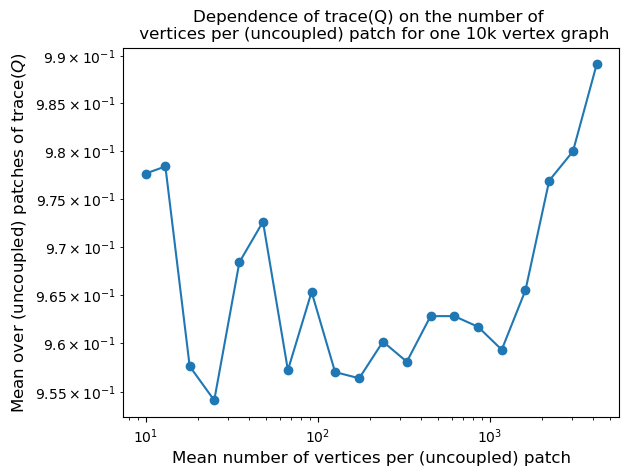

In [324]:
plt.loglog((10**np.linspace(1, 5, 30)).astype(int)[:-10], Qs_by_size[:-10], 'o-')
# plt.xlim(5e0, 1.4e3)
# plt.ylim(0.952, 0.97)
plt.xlabel("Mean number of vertices per (uncoupled) patch", fontsize=12)
plt.ylabel("Mean over (uncoupled) patches of trace($Q$)", fontsize=12)
# plt.plot([1e0, 1e4], [0.96, 0.96])
plt.title("Dependence of trace(Q) on the number of \n vertices per (uncoupled) patch for one 10k vertex graph")
# plt.savefig("trQ_by_patch_density4.png", dpi=200, bbox_inches="tight")
plt.show()

In [252]:
num_patches_per_dim = 10
R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)

In [258]:
Qs_for_all_graphs = []
for num_patches_per_dim in range(3, 40):
    print(num_patches_per_dim)
    R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)
    all_graph_Qs = []
    for patch_num in range(num_patches_per_dim**2):
        if len(R.super_V_to_V[patch_num]) != 0:
            tile_V_coords = g.V_coords[R.super_V_to_V[patch_num]]
            tile_V_coords -= np.array([patch_num % R.num_patches_per_dim, patch_num // R.num_patches_per_dim]) / R.num_patches_per_dim
            tile_V_coords *= R.num_patches_per_dim
            mini_g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                                tile_V_coords=tile_V_coords,
                                                num_horizontal_displacements=1, 
                                                num_vertical_displacements=1,
                                                autoplot=False)
            mini_R = Renormalization(mini_g, partition_type="by_tile", autoplot=False)
            Q, T = mini_R()
            Qs = []
            for i, j in zip(Q, T):
                if np.abs(j) > 1e-13:
                    Qs.append(i / j)
            all_graph_Qs.append(Qs[0])
        else:
            print(patch_num)
    Qs_for_all_graphs.append(np.trace(np.mean(all_graph_Qs, axis=0))**0.5)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
106
35
36
509
37
38
39
185
721
801
977


In [259]:
len(Qs_for_all_graphs)

37

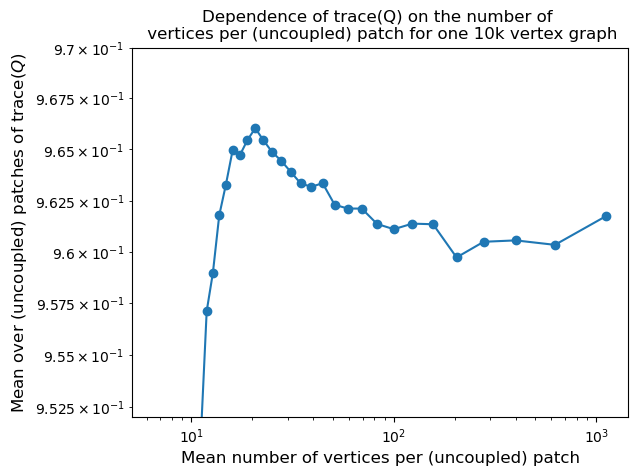

In [276]:
plt.loglog(mean_num_Vs_per_patch, Qs_for_all_graphs, 'o-')
# plt.xlim(5e0, 1.4e3)
plt.ylim(0.952, 0.97)
plt.xlabel("Mean number of vertices per (uncoupled) patch", fontsize=12)
plt.ylabel("Mean over (uncoupled) patches of trace($Q$)", fontsize=12)
# plt.plot([1e0, 1e4], [0.96, 0.96])
plt.title("Dependence of trace(Q) on the number of \n vertices per (uncoupled) patch for one 10k vertex graph")
plt.savefig("trQ_by_patch_density3.png", dpi=200, bbox_inches="tight")
plt.show()

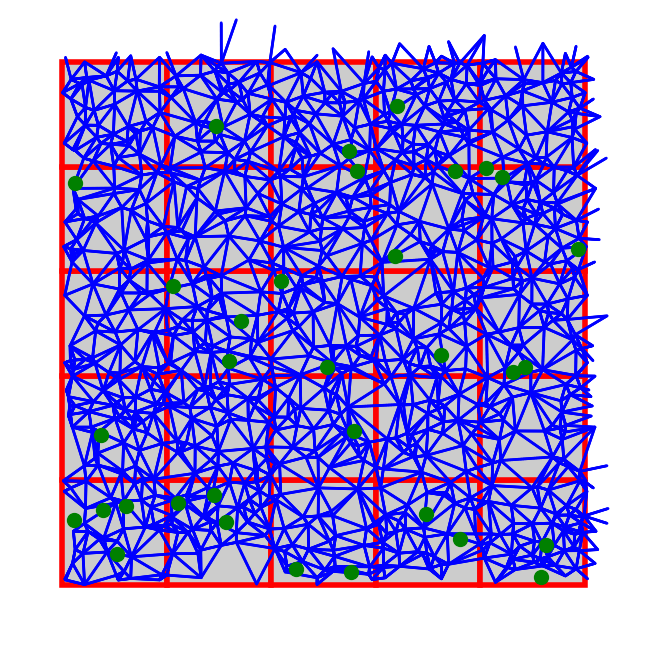

In [237]:
fig, ax = R.plot_patching(return_figax=True, figsize=7)
ax.scatter(v0[:, 0], v0[:, 1], s=100, c='g', zorder=10)

### Calculations for patching of aperiodic

In [166]:
N = 1
num_Vs_for_tile = 1000
np.random.seed(0)
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
# fig, ax = g.plot_graph(figsize=4, linewidth=1, capstyle=False, return_figax=True)
# for v_num, v_coord in enumerate(g.V_coords):
#     ax.annotate(str(v_num), v_coord, fontsize=15)

In [170]:
R = Renormalization(g, partition_type="by_tile", num_patches_per_dim=N, autoplot=False)
Q, T = R()
Qs = []
for i, j in zip(Q, T):
    if np.abs(j) > 1e-13:
        Qs.append(i / j)
meanQs = np.mean(Qs, axis=0)
print(meanQs)
print(np.trace(meanQs)**0.5)

[[0.45150958 0.00187388]
 [0.00187388 0.47057662]]
0.9602531943604686


In [77]:
traces = []
for num_patches_per_dim in range(3, 40):
    print(num_patches_per_dim)
    R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)
    Q, T = R()
    Qs = []
    for i, j in zip(Q, T):
        if np.abs(j) > 1e-13:
            Qs.append(i / j)
    meanQs = np.mean(Qs, axis=0)
    traces.append(np.trace(meanQs)**0.5)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [110]:
mean_num_Vs_per_patch = g.num_Vs / np.arange(3, 40)**2

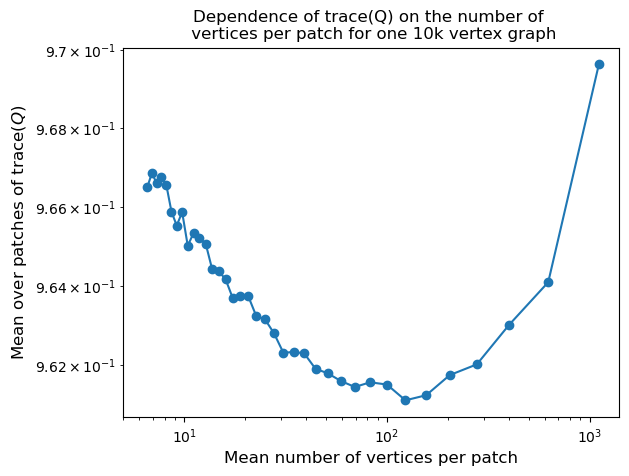

In [65]:
plt.loglog(mean_num_Vs_per_patch, traces, 'o-')
plt.xlim(5e0, 1.4e3)
# plt.ylim(0.5, 2)
plt.xlabel("Mean number of vertices per patch", fontsize=12)
plt.ylabel("Mean over patches of trace($Q$)", fontsize=12)
# plt.plot([1e0, 1e4], [0.96, 0.96])
plt.title("Dependence of trace(Q) on the number of \n vertices per patch for one 10k vertex graph")
# plt.savefig("trQ_by_patch_density1.png", dpi=200, bbox_inches="tight")
plt.show()

In [83]:
N = 1
num_Vs_for_tile = 10000
np.random.seed(0)
num_patches_per_dim = 10
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)

In [104]:
trQ_for_num_patches = []
for num_patches_per_dim in range(3, 40):
    print(num_patches_per_dim)
    R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)
    all_Qs = []
    for patch_num in range(num_patches_per_dim**2):
        patch_V_coords = g.V_coords[R.super_V_to_V[patch_num]]
        if patch_V_coords.size == 0:
            pass
        else:
            mini_g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                                tile_V_coords=patch_V_coords,
                                                num_horizontal_displacements=1, 
                                                num_vertical_displacements=1,
                                                autoplot=False, figsize=5)
            mini_R = Renormalization(mini_g, partition_type="by_tile", autoplot=False)
            Q, T = mini_R()
            Qs = []
            for i, j in zip(Q, T):
                if np.abs(j) > 1e-13:
                    Qs.append(i / j)
            all_Qs.append(Qs[0])
    trQ_for_num_patches.append(np.trace(np.mean(all_Qs, axis=0))**0.5)

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


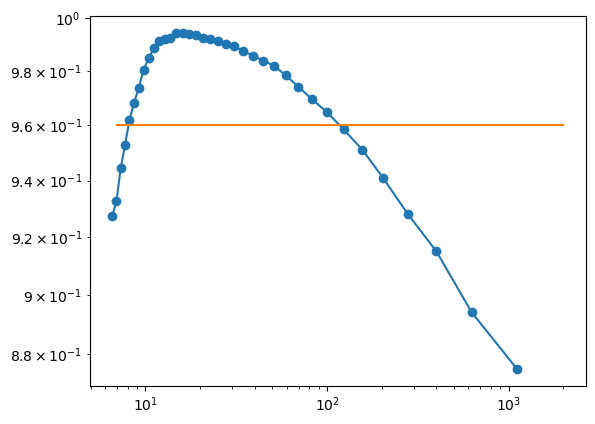

In [130]:
plt.loglog(mean_num_Vs_per_patch, np.array(trQ_for_num_patches), 'o-')
plt.plot([7e0, 2e3], [0.96, 0.96])

In [161]:
N = 1
num_Vs_for_tile = 100
np.random.seed(0)
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
num_patches_per_dim = 1
R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)
all_Qs = []
for patch_num in range(num_patches_per_dim**2):
    patch_V_coords = g.V_coords[R.super_V_to_V[patch_num]]
    if patch_V_coords.size == 0:
        pass
    else:
        mini_g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                            tile_V_coords=patch_V_coords,
                                            num_horizontal_displacements=1, 
                                            num_vertical_displacements=1,
                                            autoplot=False, figsize=5)
        mini_R = Renormalization(mini_g, partition_type="by_tile", autoplot=False)
        Q, T = mini_R()
        Qs = []
        for i, j in zip(Q, T):
            if np.abs(j) > 1e-13:
                Qs.append(i / j)
        all_Qs.append(Qs[0])
# trQ_for_num_patches.append(np.trace(np.mean(all_Qs, axis=0))**0.5)

In [162]:
np.trace(all_Qs[0])**0.5

0.9604666443614875

In [131]:
N = 1
num_Vs_for_tile = 1000
np.random.seed(1)
num_patches_per_dim = 10
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)

In [132]:
mini_g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                        tile_V_coords=g.V_coords,
                                        num_horizontal_displacements=1, 
                                        num_vertical_displacements=1,
                                        autoplot=False, figsize=5)
mini_R = Renormalization(mini_g, partition_type="by_tile", autoplot=False)
Q, T = mini_R()
Qs = []
for i, j in zip(Q, T):
    if np.abs(j) > 1e-13:
        Qs.append(i / j)

In [133]:
np.trace(Qs[0])**0.5

0.9599599545883328

In [ ]:
trQ_for_num_patches = []
for num_patches_per_dim in range(3, 40):
    print(num_patches_per_dim)
    R = Renormalization(g, partition_type="by_patch", num_patches_per_dim=num_patches_per_dim, autoplot=False)
    all_Qs = []
    for patch_num in range(num_patches_per_dim**2):
        patch_V_coords = g.V_coords[R.super_V_to_V[patch_num]]
        if patch_V_coords.size == 0:
            pass
        else:
            mini_g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                                tile_V_coords=patch_V_coords,
                                                num_horizontal_displacements=1, 
                                                num_vertical_displacements=1,
                                                autoplot=False, figsize=5)
            mini_R = Renormalization(mini_g, partition_type="by_tile", autoplot=False)
            Q, T = mini_R()
            Qs = []
            for i, j in zip(Q, T):
                if np.abs(j) > 1e-13:
                    Qs.append(i / j)
            all_Qs.append(Qs[0])
    trQ_for_num_patches.append(np.trace(np.mean(all_Qs, axis=0)))

In [103]:
(10**np.linspace(1.7, 4, 30)).astype(int)

array([   50,    60,    72,    86,   104,   124,   149,   179,   216,
         259,   311,   373,   448,   538,   646,   775,   931,  1117,
        1341,  1610,  1932,  2320,  2785,  3343,  4012,  4816,  5781,
        6940,  8330, 10000])

In [21]:
guesses = np.linspace(3.5, 5, 50)
eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
ks = eigs(guesses, printerval=100, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
_, index = np.unique(np.round(ks, 6), return_index=True)
eigenvalues = ks[index]


Calculating eig number 0

----------------------
Converged at step 5:

k = 4.192365442394002
----------------------

Calculating eig number 1

----------------------
Converged at step 5:

k = 4.192365442394001
----------------------

Calculating eig number 2

----------------------
Converged at step 5:

k = 4.192365442394005
----------------------

Calculating eig number 3

----------------------
Converged at step 5:

k = 4.192365442394008
----------------------

Calculating eig number 4

----------------------
Converged at step 5:

k = 4.192365442394013
----------------------

Calculating eig number 5

----------------------
Converged at step 5:

k = 4.1923654423940055
----------------------

Calculating eig number 6

----------------------
Converged at step 5:

k = 4.192365442393997
----------------------

Calculating eig number 7

----------------------
Converged at step 5:

k = 4.192365442394005
----------------------

Calculating eig number 8

----------------------
Converged at 

In [24]:
np.mean(eigenvalues / calculate_pde_eigenvalues(1, 0))

0.9594046696752526

### Confirmation for arbitrary patch

In [135]:
N = 5
num_Vs_for_tile = 40
np.random.seed(0)
g = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", 
                                  num_Vs_for_tile=num_Vs_for_tile,
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
# fig, ax = g.plot_graph(figsize=7, linewidth=1, capstyle=False, return_figax=True)
# for v_num, v_coord in enumerate(g.V_coords):
#     ax.annotate(str(v_num), v_coord, fontsize=15)

In [154]:
R = Renormalization(g, partition_type="by_tile", autoplot=False)
Q, T = R()
QQ = [i / j for i, j in zip(Q, T)]

In [148]:
guesses = np.linspace(3.5, 5, 50)
eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
ks = eigs(guesses, printerval=np.inf, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
_, index = np.unique(np.round(ks, 6), return_index=True)
eigenvalues = ks[index]

In [149]:
facs = np.array([QQ[0][0, 0], QQ[0][1, 1]])
def calculate_pde_eigenvalues(m, n):
    a = 2 / 2 
    return np.sqrt(((2 * np.pi * m)**2 + (2 * np.pi * n)**2) * facs)

In [150]:
print(eigenvalues / calculate_pde_eigenvalues(1, 0))

array([4.21589221, 4.30767547])

In [ ]:
class Laplace_Operator_Graph_Renormalization:

    def __init__(self, g, partition_type="tile", **kwargs):

        self.g = g
        self.partition_type = partition_type
        self.kwargs = kwargs
        self.super_V_coords, self.V_to_super_V, self.translations = self.partition_graph()
        self.E_data = self.construct_E_data()

    def partition_graph(self):
        """Partition graph based into subgraphs and return graph "super" graph consisting
        of vertices corresponding to subgraphs, connected if any of the corresponding 
        sub-vertices are. Partitions by type:
        :
            - "by_tile": uses tiling construction from Tiling class. Partitions
                        vertex set just by vertex indices

            - "by_geometric_patch": subdivides square into smaller square patches
                                    and partitions vertex set into those falling
                                    in each patch

        Returns super_V_coords: coords of vertex clumps, 
                V_to_super_V: maps graph V_coords to super graph super_V_coords
        """
        if self.partition_type == "tile":
            # Create patch coordinates, map from vertices to patches, 
            # and map from tile number to tile index (just for this function) 
            super_V_coords = []
            V_to_super_V = {}
            tile_index_to_tile_num = {}

            tile_num = -1 #g.num_horizontal_displacements * g.num_vertical_displacements
            for j in range(self.g.num_vertical_displacements):
                for i in range(self.g.num_horizontal_displacements):
                    tile_num += 1
                    v_indices = np.arange(tile_num * self.g.num_Vs_for_tile, (tile_num + 1) * self.g.num_Vs_for_tile)
                    tile = self.g.V_coords[v_indices]
                    super_V_coords.append(np.mean(tile, axis=0))
                    for v_index in v_indices:
                        V_to_super_V[v_index] = {"tile_num": tile_num, "tile_index": np.array([i, j])}

                    tile_index_to_tile_num[i, j] = tile_num

            # Calculate x, y translations by looking at displacements between tiles
            if self.g.num_horizontal_displacements < 2: 
                if self.g.horizontal_displacement < self.g.vertical_displacement:
                    x_translation = self.g.horizontal_displacement / self.g.vertical_displacement
                else:
                    x_translation = 1
            else: 
                x_translation = (super_V_coords[tile_index_to_tile_num[1, 0]] - super_V_coords[tile_index_to_tile_num[0, 0]])[0]
            if self.g.num_vertical_displacements < 2: 
                if self.g.vertical_displacement < self.g.horizontal_displacement:
                    y_translation = self.g.vertical_displacement / self.g.horizontal_displacement
                else:
                    y_translation = 1 
            else: 
                y_translation = (super_V_coords[tile_index_to_tile_num[0, 1]] - super_V_coords[tile_index_to_tile_num[0, 0]])[1]

        elif self.partition_type == "geometric_patch":
            super_V_coords = []
            V_to_super_V = {}
            tile_index_to_tile_num = bidict.bidict()

            # Determine the size of each patch
            patch_size = 1.0 / self.kwargs["tiles_per_dim"]

            # Create the super_V_coords and tile_index_to_tile_num
            for j in range(self.kwargs["tiles_per_dim"]):
                for i in range(self.kwargs["tiles_per_dim"]):
                    center_x = (i + 0.5) * patch_size
                    center_y = (j + 0.5) * patch_size
                    patch_index = j * self.kwargs["tiles_per_dim"] + i
                    super_V_coords.append([center_x, center_y])
                    tile_index_to_tile_num[i, j] = patch_index

            # Assign each vertex to the corresponding patch
            for idx, (x, y) in enumerate(self.g.V_coords):
                patch_i = np.floor(x / patch_size).astype(int)
                patch_j = np.floor(y / patch_size).astype(int)
                patch_index = patch_j * self.kwargs["tiles_per_dim"] + patch_i
                V_to_super_V[idx] = {"tile_num": patch_index, "tile_index": np.array(tile_index_to_tile_num.inv[patch_index])}

            x_translation, y_translation = patch_size, patch_size

        super_V_coords = np.array(super_V_coords)

        translations = np.array([x_translation, y_translation])

        return super_V_coords, V_to_super_V, translations

    def construct_E_data(self):
        """Needs to take in super_V_coords, and construct new connectivity between them
        based on connectivity of old graph. Then run through every edge in old graph
        and construct data (r_ij, l_vw). 
        """
        E_data = {}

        if self.partition_type == "tile":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}
                
                i, j = self.V_to_super_V[v]["tile_num"], self.V_to_super_V[w]["tile_num"]

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: #hack for calculating r_ij assuming 
                                                                            #orthogonal patching with connections
                                                                            #on checkerboard
                    a, b = (v % np.shape(self.g.tile_V_coords)[0]), (w % np.shape(self.g.tile_V_coords)[0]) 
                    if (a, b) in self.g.connectivity_map: 
                        r_ij = np.array(self.g.directions[self.g.connectivity_map[a, b][0]['direction']])
                    else: 
                        r_ij = -np.array(self.g.directions[self.g.connectivity_map[b, a][0]['direction']])
                    r_ij = r_ij * self.translations
                else:
                        r_ij = self.super_V_coords[j] - self.super_V_coords[i]

                E_data[v, w]["r_ij"] = r_ij

        elif self.partition_type == "geometric_patch":

            for v, w in zip(*self.g.wadjacency_matrix.nonzero()):
                E_data[v, w] = {"l_vw": self.g.wadjacency_matrix[v, w]}

                if (v, w) in self.g.periodic_edges or (w, v) in self.g.periodic_edges: #hack for calculating r_ij assuming 
                                                                                       #orthogonal patching with connections
                                                                                       #on checkerboard
                    i_index, j_index = self.V_to_super_V[v]["tile_index"].copy(), self.V_to_super_V[w]["tile_index"].copy()
                    r_ij = j_index - i_index
                    r_ij[r_ij == self.kwargs["tiles_per_dim"] - 1] = -1
                    r_ij[r_ij == -(self.kwargs["tiles_per_dim"] - 1)] = 1
                    r_ij = r_ij * self.translations
                else:
                    i_num, j_num = self.V_to_super_V[v]["tile_num"], self.V_to_super_V[w]["tile_num"]
                    r_ij = self.super_V_coords[j_num] - self.super_V_coords[i_num]

                E_data[v, w]["r_ij"] = r_ij

        return E_data
    
    def solve_for_bilinear_coefficients(self):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)
        
        for v, w in self.E_data:

            l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

            C[v, w] -= 1 / l_vw
            C[v, v] += 1 / l_vw

            Dx[v] += r_ij[0] / l_vw
            Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        alpha_x = scipy.sparse.linalg.lsqr(C, Dx)[0] 
        alpha_y = scipy.sparse.linalg.lsqr(C, Dy)[0]

        return alpha_x, alpha_y
    
    def partial_solve_for_bilinear_coefficients(self, num_layers):

        C = scipy.sparse.lil_matrix((self.g.num_Vs + 1, self.g.num_Vs))
        Dx = np.zeros(self.g.num_Vs + 1)
        Dy = np.zeros(self.g.num_Vs + 1)

        if self.kwargs["tiles_per_dim"] % 2 == 0:
            raise ValueError("Must have odd number of patches per dimension.")
        M = np.floor(self.kwargs["tiles_per_dim"] / 2).astype(int)
        central_tile_index = np.array([M, M])
        tiles = self.generate_anticlockwise_spiral(num_layers) + central_tile_index
                
        for v, w in self.E_data:

            if self.V_to_super_V[v]["tile_index"] in tiles:
                if self.V_to_super_V[w]["tile_index"] in tiles:
                    keep_w = 1
                else:
                    keep_w = 0

                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]

                C[v, w] -= keep_w * (1 / l_vw)
                C[v, v] += 1 / l_vw

                Dx[v] += r_ij[0] / l_vw
                Dy[v] += r_ij[1] / l_vw

        C[-1] = np.ones(self.g.num_Vs)
        C = scipy.sparse.csc_matrix(C)

        Dx[-1] = 1
        Dy[-1] = 1

        alpha_x = self.solve_reduced_sparse_system(C, Dx) 
        alpha_y = self.solve_reduced_sparse_system(C, Dy)

        return alpha_x, alpha_y, tiles
    
    def solve_reduced_sparse_system(self, A, b):
        # Create masks for rows and columns to keep
        num_rows, _ = A.shape
        mask = np.ones(num_rows, dtype=bool)
        
        row_sums = np.abs(A).sum(axis=1).A1 
        indices_to_remove = np.where(row_sums == 0)[0]

        # Set the rows and columns to remove as False in the mask
        mask[indices_to_remove] = False
        
        # Reduce the matrix and vector using the mask
        A_reduced = A[mask][:, mask[:-1]]
        b_reduced = b[mask]

        # Solve the reduced system
        x_reduced = scipy.sparse.linalg.lsqr(A_reduced, b_reduced)[0]
        
        # Initialize the solution vector for the original system
        x = np.zeros(num_rows - 1)
        
        # Place the reduced solution back into the original solution vector
        x[mask[:-1]] = x_reduced
        
        return x
    
    def __call__(self, calculation="full", return_alphas=False, num_layers=None):

        num_tiles = np.shape(self.super_V_coords)[0]

        if calculation == "full":

            alpha_x, alpha_y = self.solve_for_bilinear_coefficients()

            Q = [np.zeros((2, 2)) for _ in range(num_tiles)]
            T = [0 for _ in range(num_tiles)]

            for v, w in self.E_data:
                
                l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                alpha_v = np.array([alpha_x[v], alpha_y[v]])
                alpha_w = np.array([alpha_x[w], alpha_y[w]])
                fac = (r_ij + alpha_w - alpha_v)
                T[self.V_to_super_V[v]["tile_num"]] += l_vw
                Q[self.V_to_super_V[v]["tile_num"]] += fac[:, None] @ fac[None, :] / l_vw

        elif calculation == "partial":

            alpha_x, alpha_y, tiles = self.partial_solve_for_bilinear_coefficients(num_layers)

            Q = [np.zeros((2, 2)) for _ in range(num_tiles)]
            T = [0 for _ in range(num_tiles)]

            for v, w in self.E_data:

                if self.V_to_super_V[v]["tile_index"] in tiles:
                
                    l_vw, r_ij = self.E_data[v, w]["l_vw"], self.E_data[v, w]["r_ij"]
                    alpha_v = np.array([alpha_x[v], alpha_y[v]])
                    alpha_w = np.array([alpha_x[w], alpha_y[w]])
                    fac = (r_ij + alpha_w - alpha_v)
                    T[self.V_to_super_V[v]["tile_num"]] += l_vw
                    Q[self.V_to_super_V[v]["tile_num"]] += fac[:, None] @ fac[None, :] / l_vw

        if return_alphas:
            return Q, T, alpha_x, alpha_y
        return Q, T
    
    def generate_anticlockwise_spiral(self, num_layers):
        # Initialize the starting point
        x, y = 0, 0
        coordinates = [(x, y)]
        
        # Define the movement directions (right, up, left, down)
        directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
        
        # Initialize the step sizes for each direction
        steps = 1
        
        while len(coordinates) < (2*num_layers + 1)**2:
            for direction in directions:
                dx, dy = direction
                for _ in range(steps):
                    x += dx
                    y += dy
                    coordinates.append((x, y))
                    if len(coordinates) == (2*num_layers + 1)**2:
                        break
                if direction == directions[1] or direction == directions[3]:
                    steps += 1
                if len(coordinates) == (2*num_layers + 1)**2:
                    break
        
        return np.array(coordinates)

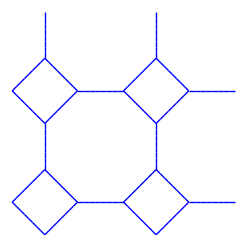

In [17]:
calculate_eigenvalues = False
N = 2
np.random.seed(6)
num_Vs_for_tile = 100
g = construct_graph.tiling.Tiling(tile_type="truncated_square", 
                                  num_Vs_for_tile=num_Vs_for_tile, 
                                  num_horizontal_displacements=N, 
                                  num_vertical_displacements=N,
                                  autoplot=False, figsize=5)
g.plot_graph(figsize=3, linewidth=1, capstyle=False)

if calculate_eigenvalues:
    guesses = np.linspace(3.5, 5, 50)
    eigs = solve_laplace_operator.solve_laplace_operator.Eigenvalue_Calculator(g)
    ks = eigs(guesses, printerval=1, max_steps=1000, tol=1e-12, solve_type="SVD iterate")
    _, index = np.unique(np.round(ks, 6), return_index=True)
    eigenvalues = ks[index]
    print(np.mean(eigenvalues) / calculate_pde_eigenvalues(1, 0))
    print(eigenvalues / calculate_pde_eigenvalues(1, 0))

In [18]:
num_patches_per_dim = 2
R = Renormalization(g, num_patches_per_dim=num_patches_per_dim, autoplot=False)
# R.plot_patching(plot_V_nums=False, figsize=5)
Q, T = R()
QQ = []
for i, j in zip(Q, T):
    if np.abs(j) > 1e-13:
        QQ.append(i / j)
print(np.trace(np.mean(QQ, axis=0)))

0.9714045207910318


In [19]:
(1+np.sqrt(2))**2/12*2

0.9714045207910317

In [74]:
tile_V_coords = g.V_coords[R.super_V_to_V[9]]
N = 1
gg = construct_graph.tiling.Tiling(tile_type="uniformly_random_Delaunay_triangulated", tile_V_coords=tile_V_coords,
                                    num_horizontal_displacements=N, 
                                    num_vertical_displacements=N,
                                    autoplot=False, figsize=5)

In [4]:
QQ = []

for num_patches_per_dim in range(3, 50):
    print(num_patches_per_dim)
    R = Renormalization(g, num_patches_per_dim=num_patches_per_dim, autoplot=False)
    Q, T = R()
    QQ.append(np.trace(np.mean([i / j for i, j in zip(Q, T)], axis=0)))

3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [9]:
mean_num_Vs_per_patch = g.num_Vs / np.arange(3, 50)**2

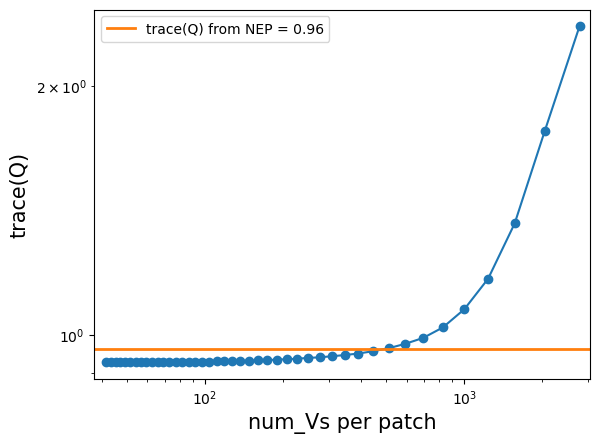

In [48]:
truncate = 3
plt.loglog(mean_num_Vs_per_patch[truncate:], QQ[truncate:], 'o-')
plt.plot([0, 5e4],[0.96, 0.96], linewidth=2, label="trace(Q) from NEP = 0.96")
plt.xlim(0.9*np.min(mean_num_Vs_per_patch[truncate:]), 1.1*np.max(mean_num_Vs_per_patch[truncate:]))
plt.xlabel("num_Vs per patch", fontsize=15)
plt.ylabel("trace(Q)", fontsize=15)
plt.legend()
plt.show()

In [49]:
# data = {"info": "seed=6, num_Vs=1e5 for uniformly_random_Delaunay_triangulated", "num_patches_per_dim": np.arange(3, 50), "trace(Q)": QQ}